In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Задача
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

### Поработаем с датасетом Cookie Cats 

Cookie Cats - это мобильная игра-головоломка, в которой игрок должен соединять плитки одного цвета, чтобы очистить игровое поле и выиграть уровень.

По мере прохождения игры игрок сталкивается с воротами. Ворота - это паузы в игре, когда игрок должен совершить покупку в приложении или подождать определенное время, прежде чем перейти на следующий уровень. Помимо обеспечения дополнительного дохода, эти ворота служат временем отдыха для игрока, что, в свою очередь, увеличивает и продлевает удовольствие от игры. 

В этом анализе мы ответим на вопрос: \
Следует ли перенести ворота с уровня 30 на уровень 40?


### Подготовка данных

In [2]:
df = pd.read_csv('ab_test2.csv', sep=',')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


### Анализ данных

In [4]:
df['userid'].nunique() # yникальные id

90189

In [5]:
df.version.value_counts()

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

#### График 

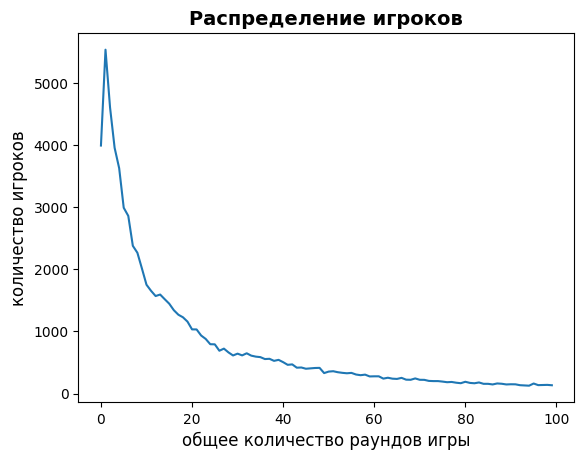

In [6]:
# Подсчет количества игроков для каждого количества раундов игры
plot_df = df.groupby('sum_gamerounds')['userid'].count() 

# Построение графика распределения игроков, сыгравших от 0 до 100 раундов игры
ax = plot_df.head(100).plot()
plt.xlabel('общее количество раундов игры', size=12)
plt.ylabel('количество игроков', size=12)
plt.title("Распределение игроков", fontweight="bold", size=14)

plt.show()

In [7]:
# Кол-во игроков установивших игру, но никогда в нее не играли
df[df['sum_gamerounds']== 0]['userid'].count()

3994

Распространенным показателем в индустрии видеоигр, показывающим, насколько увлекательной является игра, является удержание: процент игроков, которые возвращаются и играют в игру через 1 день и 7 дней после ее установки. Чем выше уровень удержания, тем легче удержать игроков и создать большую базу игроков.

In [8]:
df_retention = df[["retention_1", "retention_7"]].mean()*100
print(f"коэффициент удержания за 1 день: {round(df_retention[0],2)}% \
      \nкоэффициент удержания за 7 деней: {round(df_retention[1],2)}%")

коэффициент удержания за 1 день: 44.52%       
коэффициент удержания за 7 деней: 18.61%


In [9]:
# Показатели удержания в двух группах A/B.
df.groupby('version').agg({'userid':'count', 'retention_1':'mean', 'retention_7':'mean', 'sum_gamerounds':'sum'})

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


Из таблицы видно, что как 1-дневное, так и 7-дневное удержание немного выше для версии игры с воротами на уровне 30. 

#### Решение с помощью Bootstrap

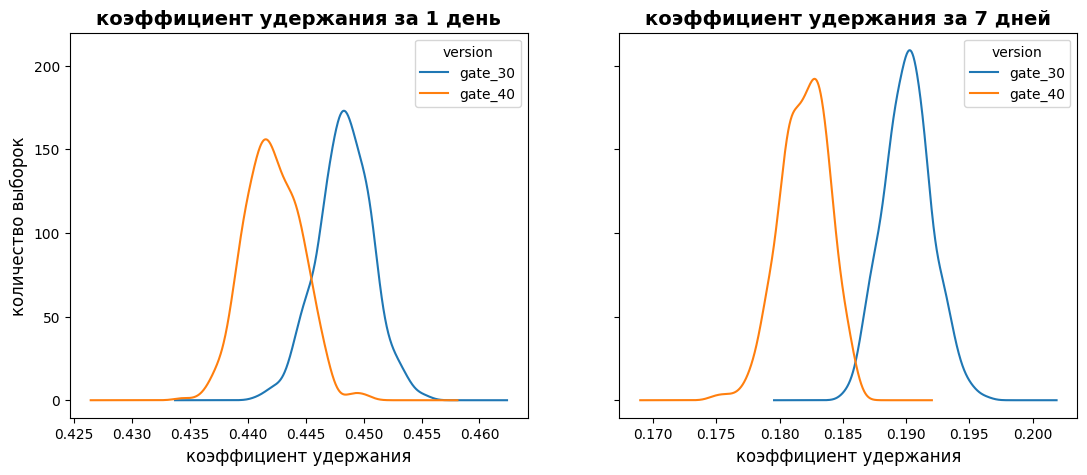

In [10]:
# Создание списка для каждой группы A/B
boot_1d = []
boot_7d = []
for i in range(500):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
# Преобразование списка в DataFrame
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

# График оценки плотности ядра для распределений
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("коэффициент удержания",size=12)
ax1.set_ylabel('количество выборок',size=12)
ax1.set_title("коэффициент удержания за 1 день", fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("коэффициент удержания",size=12)
ax2.set_title('коэффициент удержания за 7 дней', fontweight="bold",size=14)
plt.show()

Просто взглянув на графики, мы можем увидеть, что есть некоторые признаки разницы, хотя и небольшие.

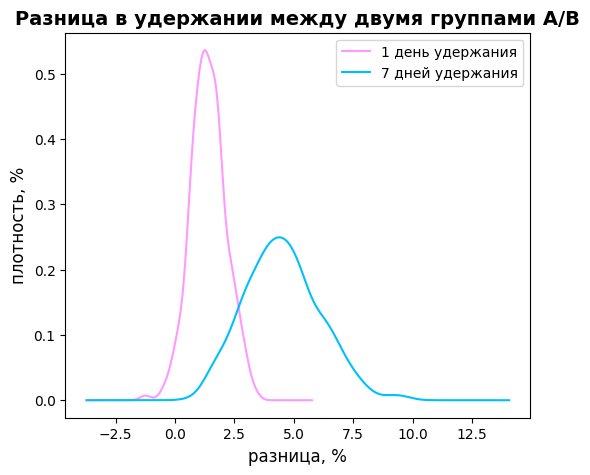

In [11]:
# Добавление столбца с разницей в % между двумя группами A/B
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

# Построение графика разницы в процентах
fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 день удержания")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 дней удержания")
ax1.set_xlabel("разница, %",size=12)
ax1.set_ylabel("плотность, %",size=12)
ax1.set_title("Разница в удержании между двумя группами A/B", fontweight="bold", size=14)
plt.legend()
plt.show()

Из графика видно, что при удержании 1 дня разница в процентах составляет около 1%-2%. А при 7 днях разница в процентах составляет около 2-5%. \
Более того, большая часть распределения превышает 0% в пользу врат на 30-м уровне.

In [17]:
# вероятность того, что задержка на 1 день будет больше, когда ворота находятся на уровне 30
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])

# вероятность того, что 7-дневное удержание будет больше, когда ворота находятся на уровне 30
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

print(f"Вероятность удержания на 1 день больше, когда ворота находятся на уровне 30: {(prob_1)*100}% \
      \nВероятность того, что 7-дневное удержание будет больше, когда ворота находятся на уровне 30: {(prob_7)*100}% ")

Вероятность удержания на 1 день больше, когда ворота находятся на уровне 30: 97.2%       
Вероятность того, что 7-дневное удержание будет больше, когда ворота находятся на уровне 30: 100.0% 


# Результат

Результат анализа показал, что 7-дневное удержание выше, когда ворота находятся на 30-м уровне, чем когда они находятся на 40-м, так же как и для 1-дневного удержания.

Если мы хотим сохранить высокий уровень удержания - как на 1 день, так и на 7 дней, - нам не следует перемещать ворота с 30-го на 40-й уровень. \
Конечно, есть и другие показатели, на которые мы могли бы обратить внимание, например, количество сыгранных игровых раундов или объем внутриигровых покупок, совершенных двумя AB-группами. 